# Create Geometry

In [1]:
import math
import numpy as np
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch.autograd import grad

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

torch.set_default_dtype(torch.float64)

In [2]:
class Shape:
    def __init__(self, node_capacity, n_neighbors):
        self.x  = np.empty(node_capacity)
        self.y  = np.empty(node_capacity)
        self.z  = np.empty(node_capacity)
        self.T0 = np.empty(node_capacity)
        self.b  = np.empty(node_capacity)
        self.a  = np.empty(node_capacity)
        self.node_id = np.empty(node_capacity)
        self.node_capacity = node_capacity 
        self.idx = 0
        self.edge_index = np.empty((2,node_capacity*n_neighbors))
        self.n_neighbors = n_neighbors
        
    def add_node(self,x,y,z,T0,b,a):
        if self.idx < self.node_capacity:
            self.x[self.idx]  = x
            self.y[self.idx]  = y
            self.z[self.idx]  = z
            self.T0[self.idx] = T0
            self.b[self.idx]  = b
            self.a[self.idx]  = a    
            self.node_id[self.idx]  = self.idx    
            
            self.idx += 1
        else:
            print(f"{self.node_capacity}: Shape at full capacity")
            
    def get_node(self, node_id):
        return [
            self.x[node_id],
            self.y[node_id],
            self.z[node_id],
            self.T0[node_id],
            self.b[node_id],
            self.a[node_id],
            self.edge_index[:,node_id*5:node_id*5+5]
        ]
    
    def _assign_neighbors(self):
        point_cloud = np.vstack((self.x,self.y,self.z)).T
        NN = NearestNeighbors(n_neighbors=self.n_neighbors, algorithm='ball_tree').fit(point_cloud)

        for i,point in enumerate(point_cloud):
            neighbors=NN.kneighbors(point.reshape(1,-1))[1][0] # neighbor idxs
            self.edge_index[0][i*self.n_neighbors:i*self.n_neighbors+self.n_neighbors]=neighbors
            self.edge_index[1][i*self.n_neighbors:i*self.n_neighbors+self.n_neighbors]=i*np.ones(neighbors.shape)
        
        self.edge_index = self.edge_index.astype(int)

            
class ShapeTime(Shape):
    def __init__(self, node_capacity, n_neighbors, time_window_start, time_window_end, time_step):
        super().__init__(node_capacity, n_neighbors)
        self.time_window_start = time_window_start
        self.time_window_end = time_window_end
        self.time_step = time_step
        
    def _add_timesteps(self):
        timesteps = np.arange(self.time_window_start, self.time_window_end, self.time_step)
        point_cloud = np.vstack((self.x,self.y,self.z,self.node_id)).T
        point_cloud_repeat = np.tile(point_cloud,(len(timesteps),1))
        timesteps_tile = np.repeat(timesteps,point_cloud.shape[0])
        self.data = np.hstack((point_cloud_repeat,timesteps_tile.reshape(-1,1)))
        
    def get_data(self):
        if self.idx == self.node_capacity:
            self._assign_neighbors()
            self._add_timesteps()
        else:
            print("add all nodes!")
        
      

In [3]:
def return_grid(x,y,z,l,w,h,sampling_rate):
    x_ = np.linspace(x, x+l, int(l*sampling_rate))
    y_ = np.linspace(y, y+w, int(w*sampling_rate))
    z_ = np.linspace(z, z+h, int(h*sampling_rate))

    x, y, z = np.meshgrid(x_, y_, z_, indexing='ij')
    
    return x,y,z

In [4]:
num_nodes=781
timestep=5
start=0
stop=60
n_neighbors = 10
num_timesteps=(stop-start)/timestep
shape = ShapeTime(num_nodes,n_neighbors,start,stop,timestep)

# Panel
x,y,z = (0,0,0)
l,w,h = (.75,0.05,.75)
sampling_rate = 30 # samples per unit length
x,y,z = return_grid(x,y,z,l,w,h,sampling_rate)
x=x.flatten()
y=y.flatten()
z=z.flatten()
a_al = 9.7e-5 # m^2/s
T0_panel = 0
b=None
for i in range(x.shape[0]):
    shape.add_node(x[i],y[i],z[i],T0_panel,b,a_al)

# block 1
x,y,z = (0.1,0,0.1)
l,w,h = (0.2,0.1,0.2)
sampling_rate = 30 # samples per unit length
x,y,z = return_grid(x,y,z,l,w,h,sampling_rate)
x=x.flatten()
y=y.flatten()
z=z.flatten()
T0_panel = 1
for i in range(x.shape[0]):
    shape.add_node(x[i],y[i],z[i],T0_panel,b,a_al)

# block 2
x,y,z = (0.6,0,0.1)
l,w,h = (0.1,0.1,0.6)
sampling_rate = 30 # samples per unit length
x,y,z = return_grid(x,y,z,l,w,h,sampling_rate)
x=x.flatten()
y=y.flatten()
z=z.flatten()
T0_panel = 0
for i in range(x.shape[0]):
    shape.add_node(x[i],y[i],z[i],T0_panel,b,a_al)

# block 3
x,y,z = (0.1,0,0.6)
l,w,h = (0.1,0.1,0.1)
sampling_rate = 30 # samples per unit length
x,y,z = return_grid(x,y,z,l,w,h,sampling_rate)
x=x.flatten()
y=y.flatten()
z=z.flatten()
T0_panel = 1
for i in range(x.shape[0]):
    shape.add_node(x[i],y[i],z[i],T0_panel,b,a_al)
    
print(shape.idx)
shape.get_data()

781


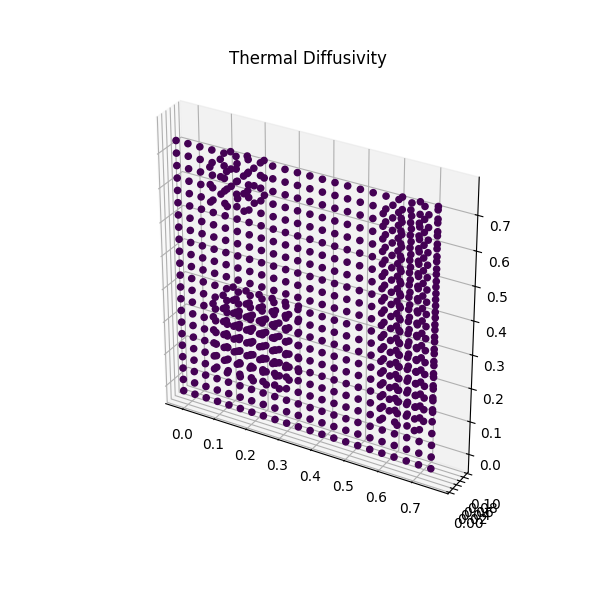

In [5]:
%matplotlib widget

# Creating figure
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection ="3d")

# Creating plot
ax.scatter3D(shape.x, shape.y, shape.z, c = shape.a, alpha=1)
#ax.view_init(210, 30)

plt.title("Thermal Diffusivity")
plt.gca().set_aspect('equal', adjustable='box')

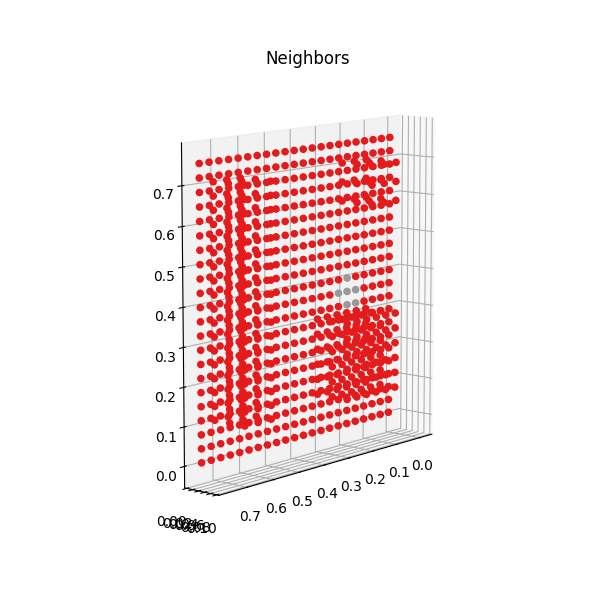

In [6]:
%matplotlib widget


# Creating figure
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection ="3d")
 
neighbors = shape.edge_index[0][1200:1206].tolist()
colors = np.zeros(shape.idx)
colors[neighbors] = 1

# Creating plot
ax.scatter3D(shape.x, shape.y, shape.z, c = colors, cmap="Set1", alpha=1)
plt.title("Neighbors")
plt.gca().set_aspect('equal', adjustable='box')
ax.view_init(10, 40)


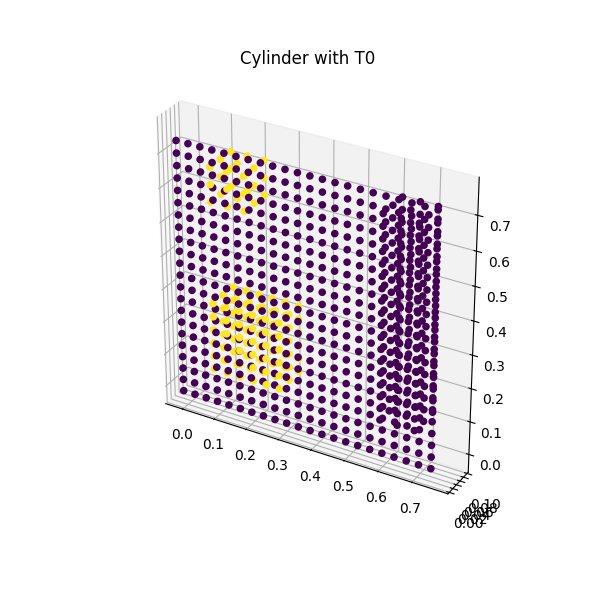

In [7]:
%matplotlib widget

# Creating figure
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(shape.x, shape.y, shape.z, c = shape.T0, alpha=1)
#ax.view_init(30, 45)
plt.title("Cylinder with T0")
plt.gca().set_aspect('equal', adjustable='box')

# Dataset and DataLoader 

In [8]:
class ShapeDataset(Dataset):
    def __init__(self, data, num_nodes, num_timesteps):
        self.data = data
        self.num_nodes = int(num_nodes)
        self.num_timesteps = int(num_timesteps)

    def __len__(self):
        return self.num_timesteps
    
    def __getitem__(self,i):
        start_idx = i*self.num_nodes
        stop_idx = (i+1)*self.num_nodes
        return self.data[start_idx:stop_idx]
    
train_dataset = ShapeDataset(shape.data, num_nodes, num_timesteps)
train_dataloader = DataLoader(train_dataset, shuffle=True)

# Model

In [9]:
class GATModel(torch.nn.Module):
    def __init__(self, num_nodes, edge_index, heads=3, hidden_dim=256):
        """
        n = number timesteps
        k = number sensors
        """
        super().__init__()
        self.num_nodes = num_nodes
        self.edge_index = edge_index
        self.hidden_dim = hidden_dim
        self.heads = heads
        self.fc1 = nn.Linear(4, hidden_dim)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=heads)
        self.gat2 = GATConv(hidden_dim*heads, hidden_dim, heads=heads)
        self.gat3 = GATConv(hidden_dim*heads, hidden_dim, heads=heads)
        self.gat4 = GATConv(hidden_dim*heads, hidden_dim, heads=heads)
        self.gat5 = GATConv(hidden_dim*heads, 1, heads=heads, concat=False)
        #self.fc1 = nn.Linear(hidden_dim*heads, hidden_dim*100)
        self.fc2 = nn.Linear(hidden_dim*100, 1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.fc1(x)
        x = self.gat_layer1(x)
        x = self.relu(x)
        x = self.gat_layer2(x)
        x = self.relu(x)
        #x = self.gat_layer3(x)
        #x = self.relu(x)
        #x = self.gat_layer4(x)
        #x = self.relu(x)
        x = self.gat_layer5(x)
        #x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc2(x)

        return x
    
    def gat_layer1(self,x):
        data = Data(x=x, edge_index=self.edge_index)
        x = self.gat1(data.x, data.edge_index)
        return x      
    def gat_layer2(self,x):
        data = Data(x=x, edge_index=self.edge_index)
        x = self.gat2(data.x, data.edge_index)
        return x      
    def gat_layer3(self,x):
        data = Data(x=x, edge_index=self.edge_index)
        x = self.gat3(data.x, data.edge_index)
        return x      
    def gat_layer4(self,x):
        data = Data(x=x, edge_index=self.edge_index)
        x = self.gat4(data.x, data.edge_index)
        return x      
    def gat_layer5(self,x):
        data = Data(x=x, edge_index=self.edge_index)
        x = self.gat5(data.x, data.edge_index)
        return x      
    

# Loss Function

In [10]:
def total_loss(u,u0,data,shape):
    u_d = torch.autograd.grad(torch.sum(u), data, retain_graph=True, create_graph=True)[0]
    u_dd = torch.autograd.grad(torch.sum(u_d), data, retain_graph=True, create_graph=True)[0]
    
    u_x = u_d[:,0]
    u_y = u_d[:,1]
    u_z = u_d[:,2]
    u_t = u_d[:,3]

    u_xx = u_dd[:,0]
    u_yy = u_dd[:,1]
    u_zz = u_dd[:,2]
    
    a = torch.tensor(shape.a)
    T0 = torch.tensor(shape.T0)
    
    # u_tt = c^2 * u_xx
    pde_loss = (a*u_xx + a*u_yy + a*u_zz - u_t)**2       

    # u0 = u_0 -> model(x,0) = u_0
    ic_loss_u = (T0 - u0)**2
    total_loss = (3/8)*pde_loss + (5/8)*ic_loss_u

    return torch.sum(total_loss)

# Training

In [11]:
model = GATModel(num_nodes, torch.tensor(shape.edge_index), hidden_dim=50)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
EPOCH=100
for epoch in range(EPOCH):
    for i,item in enumerate(train_dataloader):
        data = item.squeeze().clone()
        data = torch.hstack((data[:,0:3],data[:,4].reshape(-1,1)))
        data = data.requires_grad_(True)

        data0 = item.squeeze().clone()
        data0 = torch.hstack((data0[:,0:3],torch.zeros(num_nodes).reshape(-1,1)))
        data0 = data0.requires_grad_(True)

        optimizer.zero_grad()
        u = model(data)
        u0 = model(data0)

        loss=total_loss(u,u0.squeeze(),data,shape)   
        if i%1==0:
            print("epoch: ", epoch, ", timestep: ", i, ", loss: ", loss.item())    
        loss.backward()
        optimizer.step()    

epoch:  0 , timestep:  0 , loss:  124.74008889644446
epoch:  0 , timestep:  1 , loss:  94.38715043954683
epoch:  0 , timestep:  2 , loss:  77.37243464174682
epoch:  0 , timestep:  3 , loss:  71.42719613716676
epoch:  0 , timestep:  4 , loss:  72.33581020936032
epoch:  0 , timestep:  5 , loss:  75.09366603273
epoch:  0 , timestep:  6 , loss:  76.10738333886371
epoch:  0 , timestep:  7 , loss:  75.07920848208136
epoch:  0 , timestep:  8 , loss:  71.0099387023873
epoch:  0 , timestep:  9 , loss:  67.16199191572673
epoch:  0 , timestep:  10 , loss:  63.987011420224874
epoch:  0 , timestep:  11 , loss:  61.99611868654434
epoch:  1 , timestep:  0 , loss:  61.12949253196079
epoch:  1 , timestep:  1 , loss:  60.98907150302563
epoch:  1 , timestep:  2 , loss:  61.1642090214099
epoch:  1 , timestep:  3 , loss:  61.01597829224888
epoch:  1 , timestep:  4 , loss:  60.34284077954226
epoch:  1 , timestep:  5 , loss:  59.18237131316496
epoch:  1 , timestep:  6 , loss:  60.03990801866908
epoch:  1 , t

In [12]:
del train_dataset
del train_dataloader

# Evaluation

In [13]:
num_nodes=781
timestep=1
start=0
stop=60
n_neighbors = 10
num_timesteps=(stop-start)/timestep
shape = ShapeTime(num_nodes,n_neighbors,start,stop,timestep)

# Panel
x,y,z = (0,0,0)
l,w,h = (.75,0.05,.75)
sampling_rate = 30 # samples per unit length
x,y,z = return_grid(x,y,z,l,w,h,sampling_rate)
x=x.flatten()
y=y.flatten()
z=z.flatten()
a_al = 9.7e-5 # m^2/s
T0_panel = 0
b=None
for i in range(x.shape[0]):
    shape.add_node(x[i],y[i],z[i],T0_panel,b,a_al)

# block 1
x,y,z = (0.1,0,0.1)
l,w,h = (0.2,0.1,0.2)
sampling_rate = 30 # samples per unit length
x,y,z = return_grid(x,y,z,l,w,h,sampling_rate)
x=x.flatten()
y=y.flatten()
z=z.flatten()
T0_panel = 2
for i in range(x.shape[0]):
    shape.add_node(x[i],y[i],z[i],T0_panel,b,a_al)

# block 2
x,y,z = (0.6,0,0.1)
l,w,h = (0.1,0.1,0.6)
sampling_rate = 30 # samples per unit length
x,y,z = return_grid(x,y,z,l,w,h,sampling_rate)
x=x.flatten()
y=y.flatten()
z=z.flatten()
T0_panel = 0
for i in range(x.shape[0]):
    shape.add_node(x[i],y[i],z[i],T0_panel,b,a_al)

# block 3
x,y,z = (0.1,0,0.6)
l,w,h = (0.1,0.1,0.1)
sampling_rate = 30 # samples per unit length
x,y,z = return_grid(x,y,z,l,w,h,sampling_rate)
x=x.flatten()
y=y.flatten()
z=z.flatten()
T0_panel = 0
for i in range(x.shape[0]):
    shape.add_node(x[i],y[i],z[i],T0_panel,b,a_al)
    
print(shape.idx)
shape.get_data()

781


In [14]:
eval_dataset = ShapeDataset(shape.data, num_nodes, num_timesteps)
eval_dataloader = DataLoader(eval_dataset, shuffle=False)

In [15]:
temps = []

for data in eval_dataloader:
    data = data.squeeze().clone()
    data = torch.hstack((data[:,0:3],data[:,4].reshape(-1,1)))
    temp = model(data).detach().numpy()
    temps.append(temp)


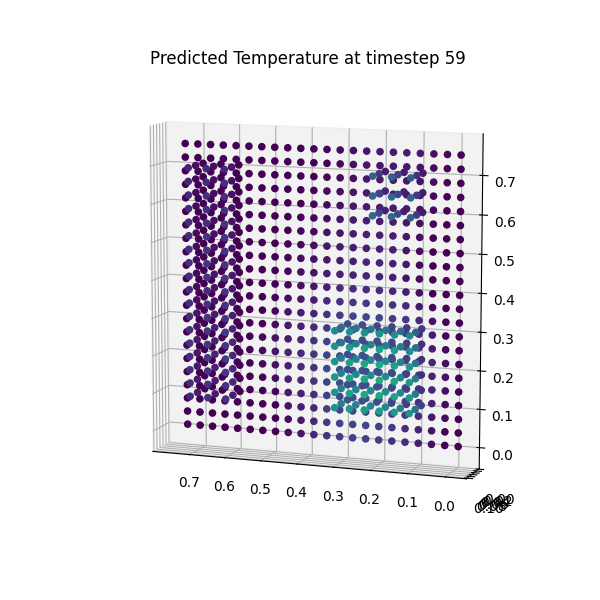

In [16]:
%matplotlib widget

# Creating figure
fig = plt.figure(figsize = (6, 6))
ax = plt.axes(projection ="3d")

# Creating plot
timestep=59

ax.scatter3D(shape.x, shape.y, shape.z, c = temps[timestep], alpha=1, vmin=0, vmax=1)
plt.title(f"Predicted Temperature at timestep {timestep}")
plt.gca().set_aspect('equal', adjustable='box')
ax.view_init(10, 110)


In [17]:
import pickle

with open("test", "wb") as fp:   #Pickling
    pickle.dump(temps, fp)
with open("test", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
sc = ax.scatter([],[],[],alpha=1)
title = ax.set_title("Predicted Temperature")
cmap = sns.color_palette("magma", as_cmap=True)
max_temp = .75

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,.75)
ax.set_ylim(0,0.1)
ax.set_zlim(0,.75)

def update(i):
    face_colors = cmap(temps[i]/max_temp)
    sc = ax.scatter(shape.x,shape.y,shape.z, facecolors=face_colors)
    title.set_text(i)
    ax.set_box_aspect([ub-lb for lb,ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])
    ax.view_init(10, 110)
    return sc,
    
ani = matplotlib.animation.FuncAnimation(fig, update, frames=59, blit=False, interval=10)
ani.save('panel_3_rear.gif', writer=PillowWriter(fps=1))

plt.gca().set_aspect('equal', adjustable='box')
plt.show()